# Collective progress

**Example notebook for creating anonymised, collective information on progress**

* Before running this notebook, you need to prepare the data you want to assess. To do so, please use the notebook - ""
* For testing, some example data is available in the folder "proc_data"
* Enter the name of the file that you wish to use in the first cell, after that you can run the full notebook with minimal changes. 

In [21]:
# import modules

# system 
import re
import os

# calculation
import pandas as pd
import numpy as np

# plotting
%matplotlib inline
import seaborn
import matplotlib

# global stocktake tools
from gst_tools.make_plots import *
import gst_tools.gst_utils as utils


## LJ notes...

The code below has been tested with
* 'UN-population-data-2017.csv'


TODOs
* clearly define 'proc-data' file format
* decide on final plots
* main functions should be transferred to gst_tools.make_plots when sufficiently tested. Easier to develop and test them here though. 

TODOs for data pre-processing
* clean out non-country codes, or make it clearly either countries OR regions
* define a file output name format. Ideally to include:
    * variable
    * source
    * ...?
* proc data can have more variables, but these will currently be dropped in pre-processing. 

In [29]:
# Choose what you would like to plot

#TODO - recommend a file name format to include the variable and the source. 
#data_file_name = 'PRIMAPHIST20-data-M0EL-KGHG.csv'
#data_file_name = 'UN-population-data-2017.csv'
data_file_name = 'PRIMAP-hist_v2.0_Energy-CO2.csv'
years_of_interest = ['1990', '2000', '2014']

# read the data from file and extract the key information
# TODO - ensure platform insensitive
data = pd.read_csv('proc-data/' + data_file_name)
variable = data['variable'].unique()[0]
unit = data['unit'].unique()[0]

data_years = utils.set_countries_as_index(data)
data_years = data_years.dropna(axis=1, how='any')

#TODO - add some checks / validation

# remove comment below to display the data
data_years

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
country,,,,,,,,,,,,,,,,,,,,,
AFG,2560.00,2380.00,1330.00,1290.00,1230.00,1180.00,1120.00,1030.00,979.00,763.00,...,1300.0,1630.00,2260.0,4190.0,6750.0,8440.00,12200.00,10700.0,9990.0,11100.0
AGO,4990.00,4960.00,5050.00,5650.00,3770.00,10900.00,10300.00,7230.00,7130.00,9050.00,...,18500.0,21600.00,24500.0,24800.0,26900.0,28300.00,29600.00,32600.0,31600.0,33500.0
ALB,3070.00,4920.00,3100.00,3000.00,3300.00,3180.00,3090.00,3270.00,4000.00,4330.00,...,3840.0,3750.00,3930.0,3980.0,4320.0,4460.00,4910.00,4310.0,4420.0,5220.0
AND,389.00,396.00,403.00,414.00,416.00,443.00,473.00,484.00,510.00,533.00,...,591.0,560.00,553.0,553.0,530.0,529.00,501.00,500.0,486.0,471.0
ARE,43700.00,47800.00,48700.00,55300.00,61000.00,59100.00,48600.00,50100.00,69700.00,67100.00,...,131000.0,138000.00,150000.0,172000.0,186000.0,179000.00,184000.00,198000.0,191000.0,239000.0
ARG,100000.00,109000.00,113000.00,113000.00,118000.00,113000.00,123000.00,126000.00,131000.00,133000.00,...,144000.0,154000.00,167000.0,171000.0,167000.0,173000.00,182000.00,182000.0,185000.0,186000.0
ARM,21000.00,19600.00,24600.00,9680.00,9650.00,10600.00,7140.00,7440.00,6220.00,4350.00,...,3820.0,3850.00,4570.0,5200.0,4270.0,4230.00,5010.00,5820.0,5620.0,5660.0
ATG,282.00,268.00,264.00,271.00,268.00,275.00,293.00,308.00,319.00,330.00,...,429.0,444.00,469.0,480.0,510.0,524.00,513.00,524.0,524.0,537.0
AUS,259000.00,261000.00,266000.00,270000.00,272000.00,284000.00,290000.00,298000.00,312000.00,320000.00,...,362000.0,368000.00,374000.0,379000.0,386000.0,381000.00,378000.00,384000.0,376000.0,372000.0


In [41]:
# main plotting function used throughout - flexibility given so that it can cope with a range of different input!

def make_histogram(df, var, unit_, remove_outliers=False, save_plot=False, kTuk=3):
    
    """
    This is based on the make_simple_histogram function but caters to data that 
    contains both positive and negative values. For the GST, it's important to be 
    able to see whether or not trends etc. are positive or negative and a symmetric
    binning approach is needed. 
    
    To calculate the bin sizes, we use a couple of conditional rules based on the data
    available, including the max and min of the data and the number of data points. 
    For most plots we are expecting around 200 countries, but could also be a few regions. 
    
    TODO - the 'outlier' calculation is helpful to see some data better BUT need to be careful. 
    Proposed solution is to make BOTH plots so that it's clear to the user when data has been
    removed.
    
    TODO - 'df' is actually a series -> better name?
    """
    
    # Check the data - needs to not be, for example, all zeros
    if len(df.unique()) == 1:
        print('---------')
        print('All values in the series are the same! Exiting plotting routine for ' + str(var))
        print('---------')
        return
    
    # set a style
    sns.set(style="darkgrid") 
    
    if remove_outliers:
        # Outliers - in some cases, the date contains extreme outliers. These make for an unreadable
        # plot and in most cases arise from exceptional circumstances. These outliers are therefore removed
        # from the plots and the removal signalled to the user. 
        # Example: Equatorial Guinea's emissions rose dramatically in the mid-90s due to the discovery of
        # oil. So much so, that the current emissions relative to 1990 are over 6000% higher. Including these
        # emissions in the plots would render a useless graph so we remove this country from the overview. 

        # Use Tukey's fences and the interquartile range to set the bounds of the data
        # https://en.wikipedia.org/wiki/Outlier
        # For reference: kTUk default is set to 3 (above)
        # k = 1.5 -> outlier; k = 3 -> far out
        # TODO - get full and proper reference for this!!!

        print('-----------')
        print('Identifying and removing outliers')

        # calculate limits
        q75, q25 = np.percentile(df, [75 ,25])
        iqr = q75 - q25                           
        tukey_min = q25 - kTuk * iqr
        tukey_max = q75 + kTuk * iqr
        # for testing:
        #print('tukey_min is ' + str(tukey_min))
        #print('tukey_max is ' + str(tukey_max))

        # Tell the user what the outliers are:
        lower_outliers = df[df < tukey_min]
        print('lower outliers are:')
        print(lower_outliers)
        upper_outliers = df[df > tukey_max]
        print('upper outliers are: ')
        print(upper_outliers)
        print('---')

        # actually remove the outliers
        df = df[(df > tukey_min) & (df < tukey_max)]

    # STATS
    # get some basic info about the data to use for setting styles, calculating bin sizes, and annotating plot
    maximum = max(df)
    minimum = min(df)
    mean = np.mean(df)
    median = np.median(df)
    npts = len(df) 
    
    # Use data metrics to determine which approach to use for bins.     
    if (minimum < 0) & (maximum > 0):

        # If both positive and negative, bins should be symmetric around 0! 
        # What's the range of data?
        full_range = np.ceil(maximum - minimum)

        # Freedman–Diaconis rule
        # (need to recalculate IQR)
        q75, q25 = np.percentile(df, [75 ,25])
        iqr = q75 - q25
        bin_width = int(2 * (iqr) / (npts ** (1/3)))
        
        # or the simple 'excel' rule:
        #bin_width = int(full_range / np.ceil(npts**(0.5)))
        
        # for nbins, need to take into account asymmetric distribution around 0
        nbins = int(np.ceil(2*max([abs(minimum), abs(maximum)])) / bin_width)
        if not (nbins/2).is_integer():
            nbins = nbins + 1
        
        # determine bin edges
        bins_calc = range(int((0-(1 + nbins/2)*bin_width)), int((0+(1 + nbins/2)*bin_width)), bin_width)                        
        print('bins set to ' + str(bins_calc))
   
        
    else:
        # use inbuilt Freedman-Diaconis
        # ? TODO - modify to ensure integers? or replicate above?
        bins_calc ='fd'
           
    # --------------        
    # MAKE THE PLOT
    
    # set up the figure
    fig, axs = plt.subplots()

    # make histogram
    sns.distplot(df, kde=False,
                 bins=bins_calc,
                 rug=True, 
                 color='mediumseagreen',
                 rug_kws={"color": "rebeccapurple", "alpha": 0.7, "linewidth": 0.4, "height": 0.03})

    # Dynamically set x axis range to make symmetric abut 0
    if minimum < 0:
        # get and reset xmin or xmax
        xmin, xmax = axs.get_xlim()
        if np.absolute(xmax) > np.absolute(xmin):
            plt.xlim(-xmax, xmax)
        else:
            plt.xlim(xmin, -xmin)
        
        # and add a line at 0
        axs.axvline(linewidth=1, color='k')
           
    # Annotate the plot with stats
    axs.annotate((" max = {:.2f}".format(maximum) + 
                  "\n min = {:.2f}".format(minimum) + 
                  "\n mean = {:.2f}".format(mean) + 
                  "\n median = {:.2f}".format(median)),
                xy=(.75, 0.75), xycoords=axs.transAxes,
                fontsize=9, color='black', 
                bbox=dict(facecolor='white', alpha=0.75))
    
    # label axes and add title
    axs.set_xlabel((var + ' (' + unit_ + ')'))
    axs.set_ylabel('Number of countries')
    axs.set_title((var + ' in ' + df.name), fontweight='bold')
    
    # show the plot
    plt.show()
    
    # save to file
    if save_plot:
        filepath = os.path.join('output', 'plots')
        fname = ('basic_histogram-' + var + '.pdf')
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        filename = os.path.join(filepath, fname)
        plt.savefig(filename, format='pdf')
        plt.close()


-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 1990, dtype: float64)
upper outliers are: 
country
AUS     259000.0
CAN     430000.0
CHN    2320000.0
DEU     990000.0
ESP     211000.0
FRA     368000.0
GBR     578000.0
IND     559000.0
IRN     204000.0
ITA     410000.0
JPN    1080000.0
KAZ     245000.0
KOR     246000.0
MEX     280000.0
POL     361000.0
RUS    2360000.0
UKR     592000.0
USA    4930000.0
ZAF     278000.0
Name: 1990, dtype: float64
---


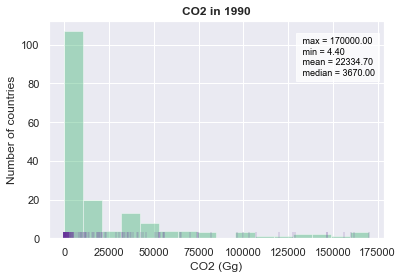

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2000, dtype: float64)
upper outliers are: 
country
AUS     327000.0
BRA     268000.0
CAN     531000.0
CHN    3150000.0
DEU     840000.0
ESP     287000.0
FRA     385000.0
GBR     545000.0
IDN     264000.0
IND     962000.0
IRN     361000.0
ITA     444000.0
JPN    1190000.0
KOR     410000.0
MEX     366000.0
POL     302000.0
RUS    1360000.0
SAU     235000.0
UKR     216000.0
USA    5800000.0
ZAF     336000.0
Name: 2000, dtype: float64
---


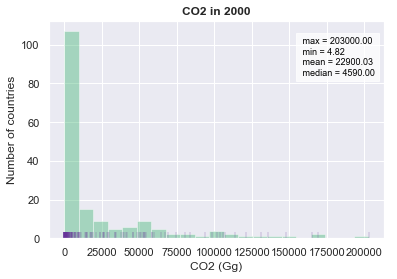

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
ARE     239000.0
AUS     372000.0
BRA     430000.0
CAN     526000.0
CHN    8810000.0
DEU     745000.0
ESP     235000.0
FRA     313000.0
GBR     420000.0
IDN     338000.0
IND    1880000.0
IRN     617000.0
ITA     332000.0
JPN    1200000.0
KAZ     235000.0
KOR     589000.0
MEX     459000.0
MYS     227000.0
POL     287000.0
RUS    1480000.0
SAU     470000.0
THA     299000.0
TUR     305000.0
USA    5380000.0
ZAF     398000.0
Name: 2014, dtype: float64
---


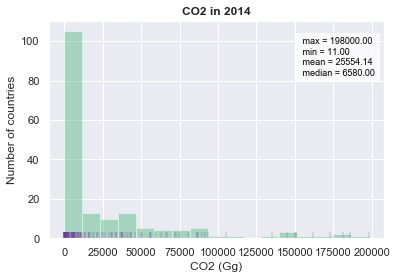

In [30]:
# Plot 1 - make a histogram of absolute data

for selected_year in years_of_interest:
    make_histogram(data_years[selected_year], variable, unit, remove_outliers=True)


Averaging trend over 5 years.
bins set to range(-38, 38, 2)


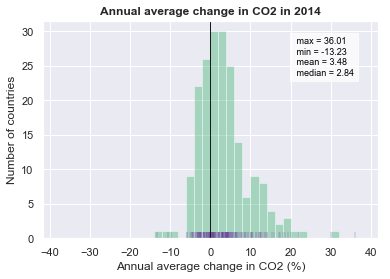

In [31]:
# Plot 2 - trends

def calculate_trends(df, num_years_trend=10): 
    
    # disp average used for trend
    print('Averaging trend over ' + str(num_years_trend) + ' years.')
    
    # calculate annual % changes
    df_perc_change = df.pct_change(axis='columns') * 100
    new_unit = '%'
    
    # average over a window
    df_rolling_average = df_perc_change.rolling(window=num_years_trend, axis='columns').mean()
    
    return df_rolling_average, new_unit

# Calculate trends and define plotting params    
# TODO - improve description here. 
trends_df, trends_unit = calculate_trends(data_years, num_years_trend=5)
trends_variable = 'Annual average change in ' + variable

# plot the trend in the final year
make_histogram(trends_df.iloc[:,-1], trends_variable, trends_unit)


Calculating difference compared to 1990
Calculating difference compared to 2005
---------
All values in the series are the same! Exiting plotting routine for change since 1990
---------
-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2000, dtype: float64)
upper outliers are: 
country
GNQ    589.393939
LAO    313.425926
NPL    406.944444
SYC    281.333333
TGO    359.770115
TLS    354.545455
Name: 2000, dtype: float64
---
bins set to range(-252, 252, 21)


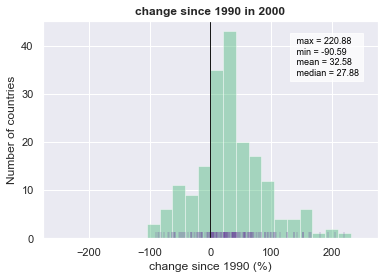

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
BEN     907.168459
GNQ    8006.060606
NPL    1025.000000
QAT     805.172414
TGO     788.888889
Name: 2014, dtype: float64
---
bins set to range(-792, 792, 66)


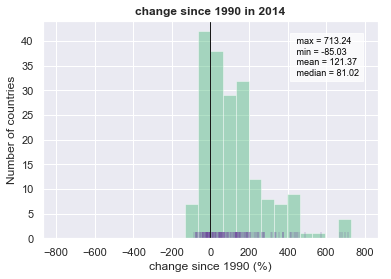

bins set to range(-780, 780, 20)


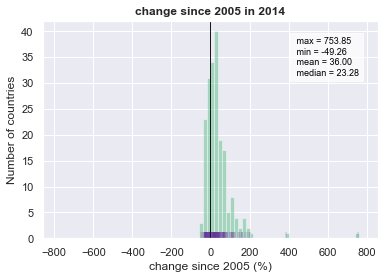

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
AFG    753.846154
MOZ    386.075949
Name: 2014, dtype: float64
---
bins set to range(-216, 216, 18)


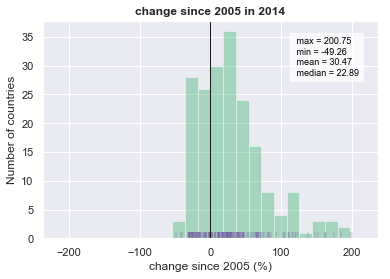

In [42]:
# plot 3 - change since year X

def calculate_diff_since_yearX(df_abs, yearX):
    
    print('Calculating difference compared to ' + yearX)
    
    # first, check that the desired year is in the data!
    if yearX not in df_abs.columns:
        print('The year you have selected for relative calculations ('
               + str(yearX) + ') is not available, please try again.')
        return
    
    
    # calculate all columns relative to the chosen year, first in absolute terms, then %
    df_abs_diff = df_abs.subtract(df_abs[yearX], axis='index')
    #print(df_abs_diff)
    df_perc_diff = 100 * df_abs_diff.divide(df_abs[yearX], axis='index')
    #print(df_perc_diff)
    
    return df_abs_diff, df_perc_diff


# run calculations
df_abs_diff_1990, df_perc_diff_1990 = calculate_diff_since_yearX(data_years, '1990')
df_abs_diff_2005, df_perc_diff_2005 = calculate_diff_since_yearX(data_years, '2005')

# make plots
for selected_year in years_of_interest:
    make_histogram(df_perc_diff_1990[selected_year], "change since 1990", "%", remove_outliers=True, kTuk=3)

make_histogram(df_perc_diff_2005.iloc[:,-1], "change since 2005", '%', remove_outliers=False)
make_histogram(df_perc_diff_2005.iloc[:,-1], "change since 2005", '%', remove_outliers=True)


In [40]:
nbins = 5


    
nbins

6